<a href="https://colab.research.google.com/github/akashdhanpal/Pnemonia_Detection_CV_Deep_Learning/blob/main/Capstone_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/My Drive/Capstone/

/content/drive/My Drive/Capstone


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 12.6MB/s 


In [ ]:
import glob, pylab, pandas as pd
import pydicom as dicom
import numpy as np
from os import listdir
from os.path import isfile, join

In [ ]:
labels = pd.read_csv('/content/drive/My Drive/Capstone/stage_2_train_labels.csv')

In [ ]:
print(labels.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


In [ ]:
# read a single patient dicom image file to check its header and metadata

patientId = labels['patientId'][0]
dcm_file = '/content/drive/My Drive/Capstone/stage_2_train_images/%s.dcm' % patientId
dcm_data = dicom.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
# Accessing underlying pixel data

im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

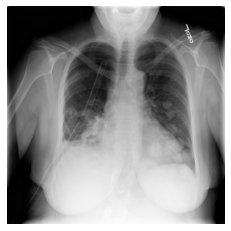

In [ ]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

#**Basic EDA**

In [ ]:
import gc
import warnings
warnings.simplefilter(action = 'ignore')

In [ ]:
# Load the data

class_info = pd.read_csv('/content/drive/My Drive/Capstone/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('/content/drive/My Drive/Capstone/stage_2_train_labels.csv')

data = pd.merge(left = class_info, right = train_labels, how = 'left', on = 'patientId')

del class_info, train_labels
gc.collect()

data.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  37629 non-null  object 
 1   class      37629 non-null  object 
 2   x          16957 non-null  float64
 3   y          16957 non-null  float64
 4   width      16957 non-null  float64
 5   height     16957 non-null  float64
 6   Target     37629 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 2.3+ MB


In [ ]:
data.shape  

In [ ]:
data.head(10)

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1
6,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
7,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1
8,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0


In [ ]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
data.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


Rows per patient ID

In [ ]:
data['patientId'].value_counts().head()

ee820aa5-4804-4984-97b3-f0a71d69702f    4
0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
349f10b4-dc3e-4f3f-b2e4-a5b81448ce87    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
0d5bc737-03de-4bb8-98a1-45b7180c3e0f    4
Name: patientId, dtype: int64

In [ ]:
# checking a single patient ID

data[data['patientId'] == '0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d']

,patientId,class,x,y,width,height,Target
36153,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,Lung Opacity,654.0,444.0,160.0,103.0,1
36154,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,Lung Opacity,531.0,206.0,289.0,213.0,1
36155,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,Lung Opacity,686.0,545.0,128.0,106.0,1
36156,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,Lung Opacity,213.0,386.0,114.0,161.0,1


In [ ]:
# Total number of patients

data['patientId'].count()


30227

In [ ]:
# Patients having Pneumonia

data[data['Target'] == 1]['patientId'].count()

9555

In [ ]:
# Each of patients without pneumonia has only one row in dataset

data[data['Target'] == 0]['patientId'].count()

20672

#Plots to check the distribution of data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

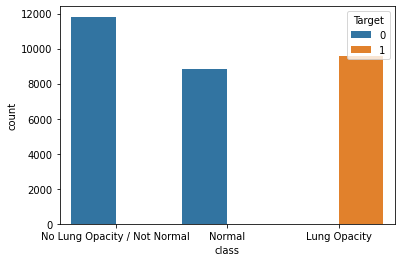

In [ ]:
sns.countplot(x = 'class', hue = 'Target', data=data);

In [ ]:
data['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

This means that only the class "Lung Opacity" are the patients having Pneumonia in the dataset and they have a "Target" set as 1 against them

The other two classes(No Lung Opacity / Not Normal, Normal) have a "Target" set as 0 against them which means they do not have Pneumonia

In [ ]:
# Checking few statistics of bounding box coordinates

area = data.dropna()[['x', 'y', 'width', 'height']].copy()

In [ ]:
area.head()

,x,y,width,height
4,264.0,152.0,213.0,379.0
5,562.0,152.0,256.0,453.0
10,323.0,577.0,160.0,104.0
11,695.0,575.0,162.0,137.0
18,288.0,322.0,94.0,135.0


In [ ]:
area.describe()

,x,y,width,height
count,9555.000000,9555.000000,9555.000000,9555.000000
mean,394.047724,366.839560,218.471376,329.269702
std,204.574172,148.940488,59.289475,157.750755
min,2.000000,2.000000,40.000000,45.000000
25%,207.000000,249.000000,177.000000,203.000000
50%,324.000000,365.000000,217.000000,298.000000
75%,594.000000,478.500000,259.000000,438.000000
max,835.000000,881.000000,528.000000,942.000000


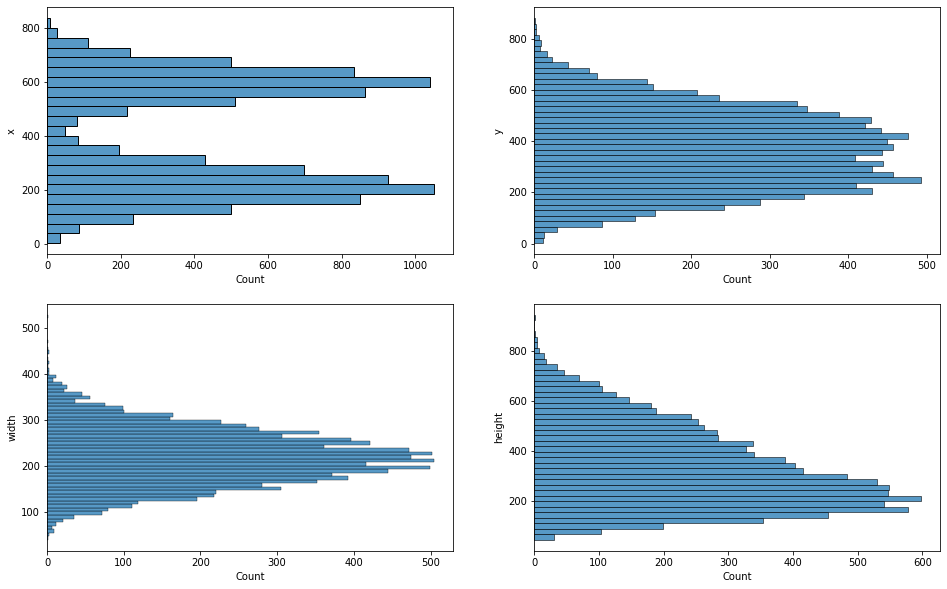

In [ ]:
n_columns = 2
n_rows = 2
_, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 5 * n_rows))
for i, c in enumerate(area.columns):
    sns.histplot(y = c, data = area, ax = axes[i // n_columns, i % n_columns])
#plt.tight_layout()
plt.show()

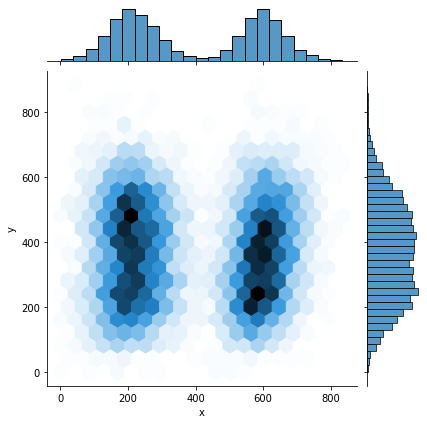

In [ ]:
# jointplot

sns.jointplot(x = 'x', y = 'y', data = area, kind = 'hex', gridsize = 20);

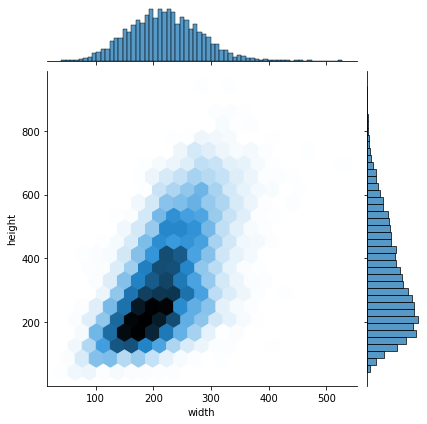

In [ ]:
sns.jointplot(x = 'width', y = 'height', data = area, kind = 'hex', gridsize = 20);

Above plot shows that width and height have very tight correlation

# Analysis of meta information

In [ ]:
data_meta = data.drop('class', axis=1).copy()

In [ ]:
data_meta.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
from  tqdm import tqdm

In [ ]:
patientId = data_meta['patientId'].drop_duplicates().values
pat = patientId[:26684]
patient_info = pd.DataFrame()

for p in tqdm(pat):
    ds = dicom.dcmread('/content/drive/My Drive/Capstone/stage_2_train_images/%s.dcm' % p, stop_before_pixels=True, defer_size='10 KB', specific_tags=[(0x0010, 0x1010), (0x0010, 0x0040), (0x0010, 0x0020), (0x0018, 0x5101)])
    tmp_info = pd.DataFrame({
        'patientId': [ds.PatientID],
        'age': [ds.PatientAge],
        'sex': [ds.PatientSex],
        'viewPosition': [ds.ViewPosition]
    })
    patient_info = patient_info.append(tmp_info)


# for p in pat:
#   dcm_file = '/content/drive/My Drive/Capstone/stage_2_train_images/%s.dcm' % p
#   dcm_data = dicom.dcmread(dcm_file, stop_before_pixels=True, specific_tags=[(0x0010, 0x1010), (0x0010, 0x0040), (0x0010, 0x0020), (0x0018, 0x5101)])
#   print(dcm_data)

100%|██████████| 26684/26684 [4:35:13<00:00,  1.62it/s]


In [ ]:
patient_info.to_csv('/content/drive/My Drive/Capstone/patient_info.csv')

In [ ]:
patient_data = pd.read_csv('../Capstone/patient_info.csv', usecols=['patientId', 'age', 'sex', 'viewPosition'])

In [ ]:
data_merged = pd.merge(data, patient_data, on='patientId')

In [ ]:
data_merged.head()

,patientId,class,x,y,width,height,Target,age,sex,viewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,51,F,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,48,F,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,19,M,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0,28,M,PA
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,32,F,AP


In [ ]:
data_merged.shape

(30227, 10)

In [ ]:
data_unique = data_merged.drop_duplicates('patientId', keep='first')

In [ ]:
data_unique.shape

(26684, 10)

# Patient Age vs Target


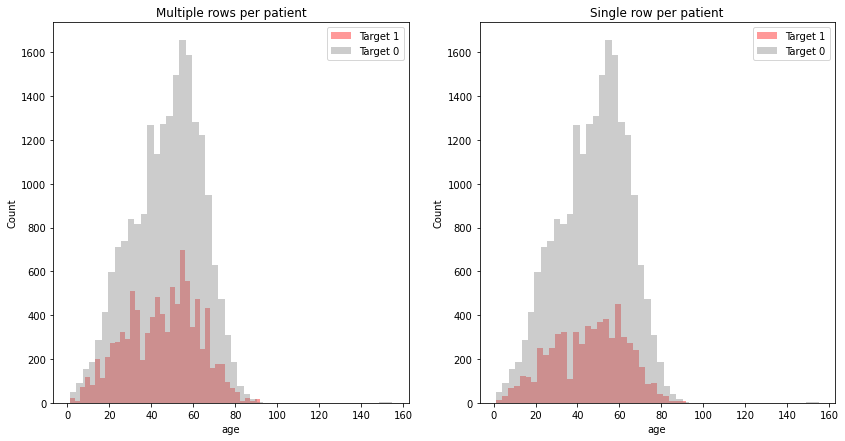

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(data_merged[data_merged['Target']==1]['age'], hist=True, kde=False, color='red', label='Target 1', ax=axes[0])
p = sns.distplot(data_merged[data_merged['Target']==0]['age'], hist=True, kde=False, color='gray', label='Target 0', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Multiple rows per patient')

p = sns.distplot(data_unique[data_unique['Target']==1]['age'], hist=True, kde=False, color='red', label='Target 1', ax=axes[1])
p = sns.distplot(data_unique[data_unique['Target']==0]['age'], hist=True, kde=False, color='gray', label='Target 0', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Single row per patient')

# Patient Age vs Class

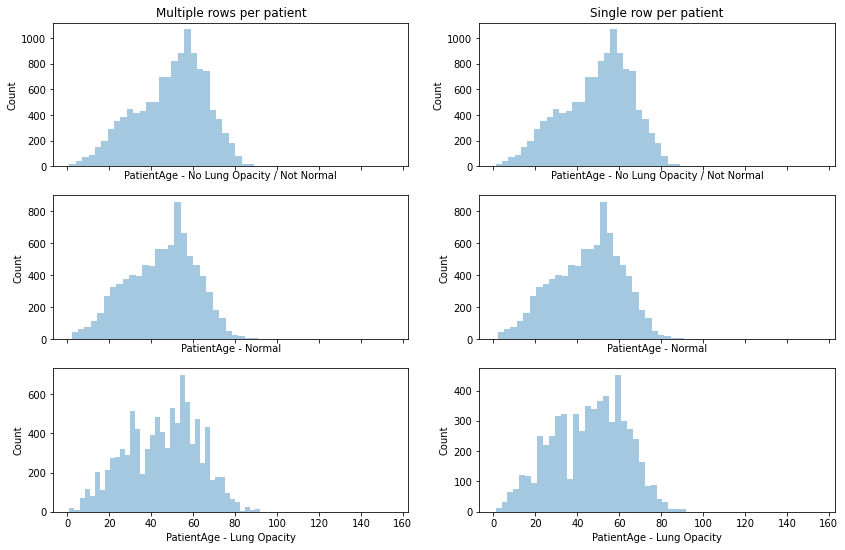

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)
for i, _class in enumerate(data_merged['class'].dropna().unique()):
    p = sns.distplot(data_merged[data_merged['class']==_class]['age'], hist=True, kde=False, ax=axes[i, 0])
    _ = p.set_ylabel('Count')
    _ = p.set_xlabel(f'PatientAge - {_class}')
    if i == 0: p.set_title('Multiple rows per patient')
    
    p = sns.distplot(data_unique[data_unique['class']==_class]['age'], hist=True, kde=False, ax=axes[i, 1])
    _ = p.set_ylabel('Count')
    _ = p.set_xlabel(f'PatientAge - {_class}')
    if i == 0: p.set_title('Single row per patient')

# Patient Sex vs Target

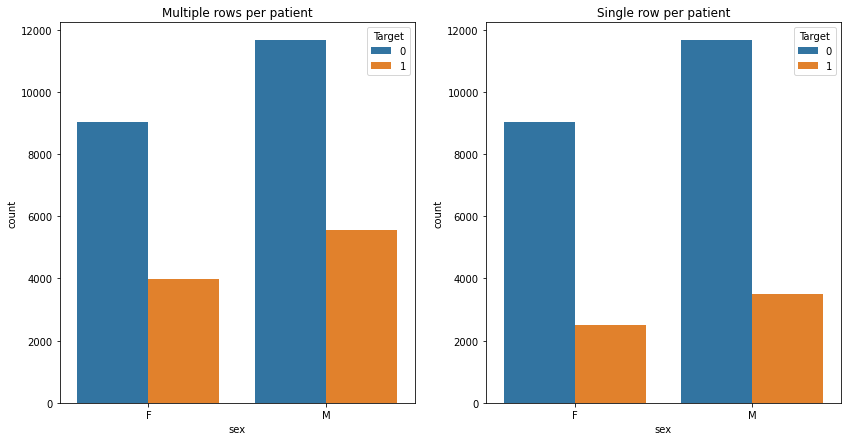

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='sex', hue='Target', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.countplot(x='sex', hue='Target', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

#Patient Sex vs Class

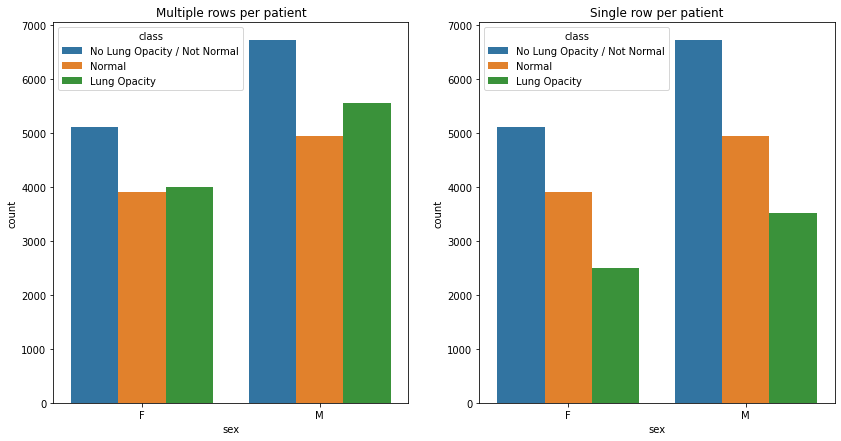

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='sex', hue='class', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.countplot(x='sex', hue='class', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

# Patient Age & Sex vs Target

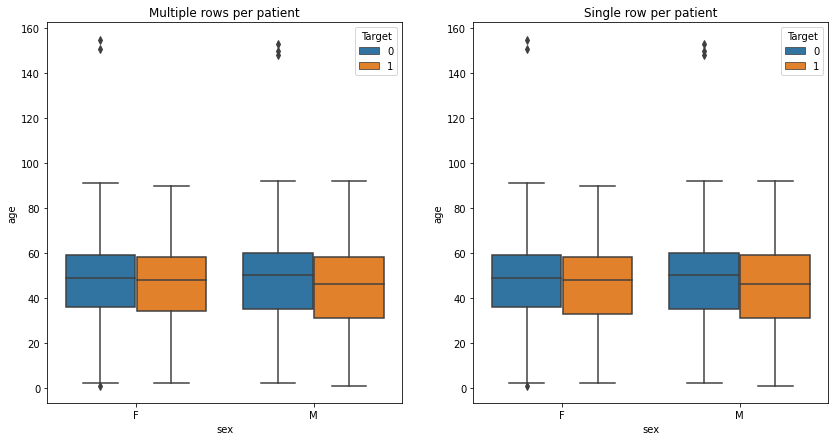

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='sex', y='age', hue='Target', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.boxplot(x='sex', y='age', hue='Target', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

# Patient Age & Sex vs Class

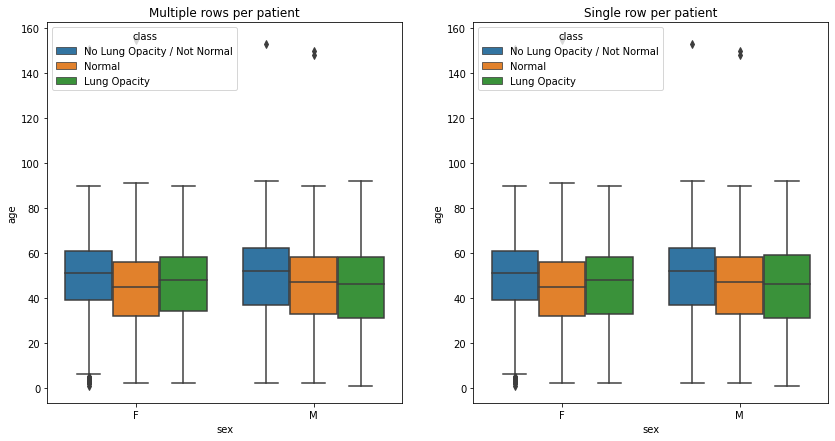

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='sex', y='age', hue='class', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.boxplot(x='sex', y='age', hue='class', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

# Patient Age vs ViewPosition

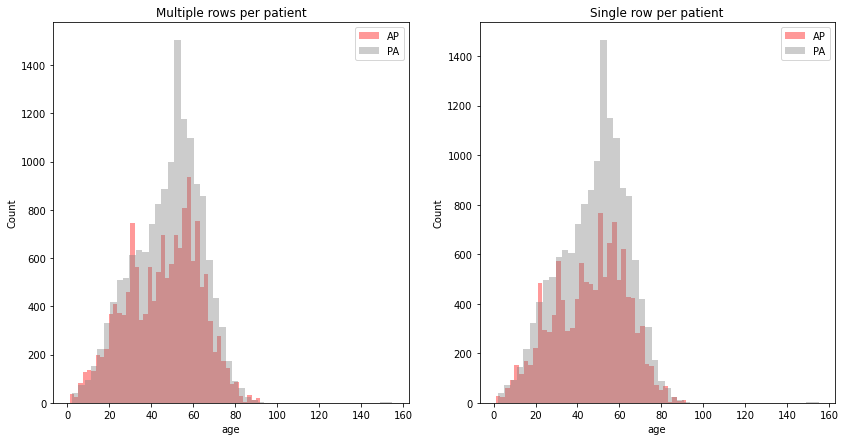

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(data_merged[data_merged['viewPosition']=='AP']['age'], hist=True, kde=False, color='red', label='AP', ax=axes[0])
p = sns.distplot(data_merged[data_merged['viewPosition']=='PA']['age'], hist=True, kde=False, color='gray', label='PA', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Multiple rows per patient')

p = sns.distplot(data_unique[data_unique['viewPosition']=='AP']['age'], hist=True, kde=False, color='red', label='AP', ax=axes[1])
p = sns.distplot(data_unique[data_unique['viewPosition']=='PA']['age'], hist=True, kde=False, color='gray', label='PA', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Single row per patient')

# Patient ViewPosition vs Sex

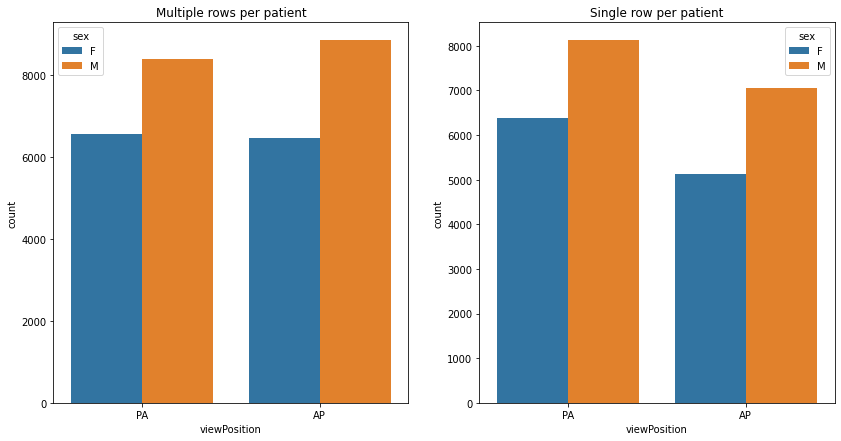

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='viewPosition', hue='sex', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.countplot(x='viewPosition', hue='sex', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

# Patient ViewPosition vs Target

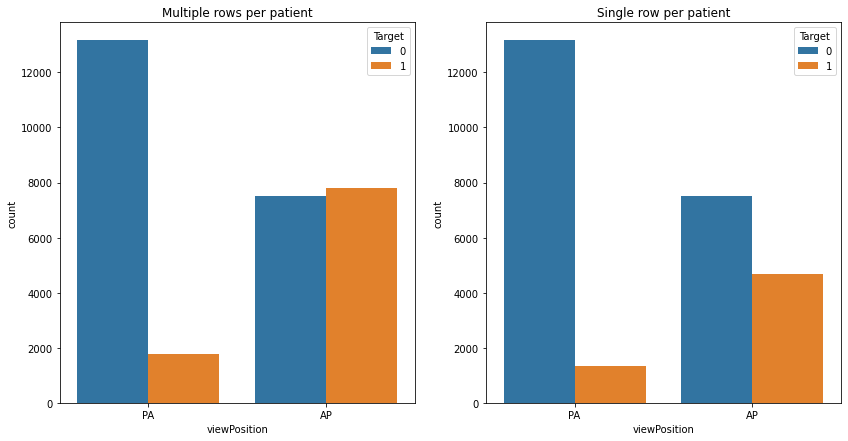

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='viewPosition', hue='Target', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.countplot(x='viewPosition', hue='Target', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

# Patient ViewPosition vs Class

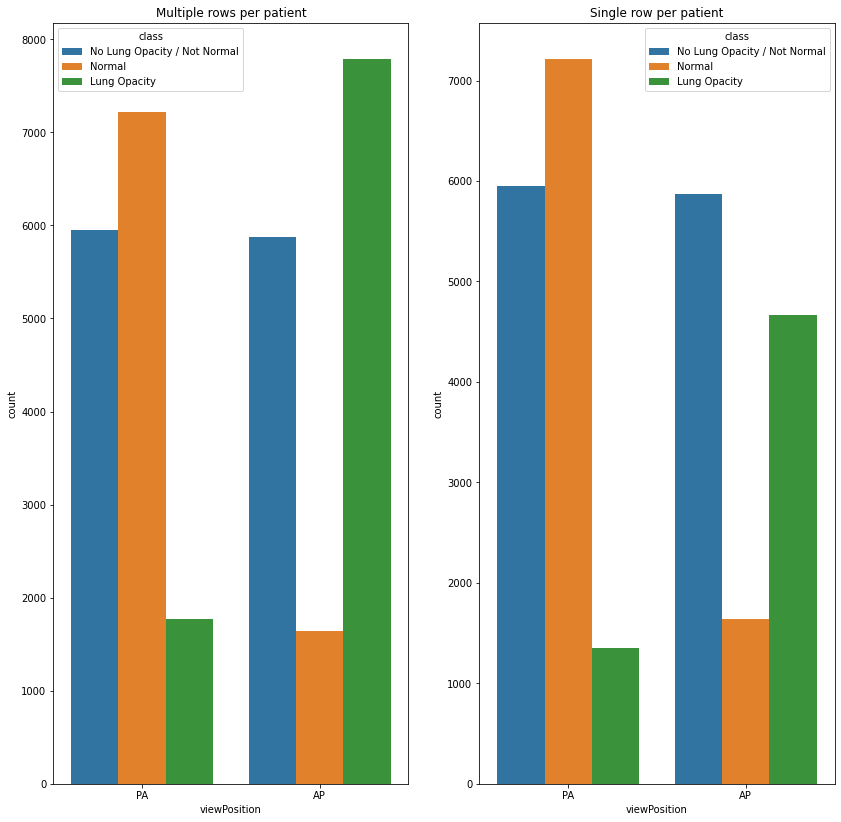

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 14))
p = sns.countplot(x='viewPosition', hue='class', data=data_merged, ax=axes[0])
_ = p.set_title('Multiple rows per patient')
p = sns.countplot(x='viewPosition', hue='class', data=data_unique, ax=axes[1])
_ = p.set_title('Single row per patient')

#Displaying the train images

In [ ]:
train_images_dir = '/content/drive/My Drive/Capstone/stage_2_train_images/'
train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]

In [ ]:
#Plotting a few train images
plt.style.use('default')
fig=plt.figure(figsize=(10, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    ds = dicom.dcmread(train_images_dir + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

In [ ]:
#Converting csv into data dictionary so as to get the path of dicom file, target and bounding box coordinate for a patient id all into one structure
def parse_data(df):
  extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

  parsed = {}
  for n, row in df.iterrows():
  #Initialize patient entry into parsed 
      pid = row['patientId']
      if pid not in parsed:
          parsed[pid] = {
                'dicom': '/content/drive/My Drive/Capstone/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

#Add box if opacity is present
      if parsed[pid]['label'] == 1:
          parsed[pid]['boxes'].append(extract_box(row))
  return parsed

In [ ]:
#Using the parse_data function for our data and checking one entry
parsed = parse_data(data)
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

In [ ]:
#Function to draw single patient bounding box on the image

def draw(df):
    #Open DICOM file
    d = dicom.read_file(df['dicom'])
    im = d.pixel_array

    #Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    #Add boxes with red color if present
    for box in df['boxes']:
        rgb = [255, 0, 0]
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

#Function to get a coloured boundary box in the image
def overlay_box(im, box, rgb, stroke=1):
    #Convert coordinates to integers
    box = [int(b) for b in box]
    
    #Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [ ]:
#Looking at images with boxes plotted
plt.style.use('default')
fig=plt.figure(figsize=(10, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[data['patientId'].unique()[i]])
    fig.add_subplot

In [ ]:
#Comapring the 3 classses : Opacity, Normal and Not Normal
opacity = data \
    .loc[data['class'] == 'Lung Opacity'] \
    .reset_index()
not_normal = data \
    .loc[data['class'] == 'No Lung Opacity / Not Normal'] \
    .reset_index()
normal = data \
    .loc[data['class'] == 'Normal'] \
    .reset_index()

fig=plt.figure(figsize=(10, 10))
columns = 3; rows = 1
fig.add_subplot(rows, columns, 1).set_title("Normal", fontsize=30)
draw(parsed[normal['patientId'].unique()[0]])
fig.add_subplot(rows, columns, 2).set_title("Not Normal", fontsize=30)
# ax2.set_title("Not Normal", fontsize=30)
draw(parsed[not_normal['patientId'].unique()[0]])
fig.add_subplot(rows, columns, 3).set_title("Opacity", fontsize=30)
# ax3.set_title("Opacity", fontsize=30)
draw(parsed[opacity['patientId'].unique()[0]])